# Case Study of equipment’s signal quality

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks')

PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo

In [3]:
#checking tensorflow version
import tensorflow as tf
tf.__version__

'2.5.0'

1. Import data. 

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import keras
from keras.layers import Dense,Conv2D,Dropout,BatchNormalization,Activation,Flatten,MaxPool2D,Input,LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Reshape
from keras.optimizers import SGD
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import h5py

In [5]:
import cv2
import numpy as np
from glob import glob
import seaborn as sns

Load the dataset from drive

In [6]:
# Train data path "/content/drive/MyDrive/Colab Notebooks/Dataset - Plant-seedlings-classification"
train_data_folder = "Dataset - Plant-seedlings-classification/train"

In [7]:
classes= []
for class_folder_name in os.listdir(train_data_folder):
    class_folder_path = os.path.join(train_data_folder, class_folder_name)
    class_label = class_folder_name
    classes.append(class_label)

classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Scentless Mayweed',
 'Maize',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Shepherds Purse']

In [8]:
train = []

for species_num, species in enumerate(classes):
    for file in os.listdir(os.path.join(train_data_folder, species)):
        train.append(['{}/{}/{}'.format(train_data_folder,species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (4750, 3)


In [9]:
train.head()

,file,species_num,species
0,Dataset - Plant-seedlings-classification/train...,0,Black-grass
1,Dataset - Plant-seedlings-classification/train...,0,Black-grass
2,Dataset - Plant-seedlings-classification/train...,0,Black-grass
3,Dataset - Plant-seedlings-classification/train...,0,Black-grass
4,Dataset - Plant-seedlings-classification/train...,0,Black-grass


In [10]:
train['file'][1]

'Dataset - Plant-seedlings-classification/train/Black-grass/05eedce4d.png'

In [11]:

images = []

for i in range(len(train)):
    #print ( train['file'][i])
    image_bgr = cv2.imread( train['file'][i], cv2.IMREAD_COLOR)
    if image_bgr is None: # if the file contain any missig value ignore it
       continue
    images.append(image_bgr)



In [12]:
images[2]

array([[[ 27,  50,  80],
        [ 18,  42,  71],
        [ 36,  57,  83],
        ...,
        [ 58,  85,  93],
        [ 64,  93,  99],
        [ 48,  82,  88]],

       [[ 20,  45,  77],
        [ 23,  46,  78],
        [ 39,  59,  86],
        ...,
        [ 63,  85,  94],
        [ 59,  82,  91],
        [ 49,  75,  84]],

       [[ 20,  45,  78],
        [ 26,  50,  82],
        [ 39,  59,  87],
        ...,
        [ 63,  81,  92],
        [ 58,  77,  89],
        [ 59,  78,  90]],

       ...,

       [[154, 147, 141],
        [159, 153, 146],
        [155, 149, 142],
        ...,
        [101,  96,  94],
        [ 65,  59,  64],
        [ 57,  50,  56]],

       [[155, 149, 142],
        [156, 150, 143],
        [155, 149, 141],
        ...,
        [ 94,  88,  86],
        [ 72,  66,  70],
        [ 64,  58,  62]],

       [[156, 149, 141],
        [157, 151, 143],
        [155, 149, 140],
        ...,
        [ 97,  91,  89],
        [ 72,  66,  69],
        [ 60,  54,  58]]

In [13]:
print("Number of images in folder", len(images))
print("Class label", len((classes)))

Number of images in folder 4750
Class label 12


In [14]:
# Resize the images
def resizeImages(img):
  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [15]:
#saving resized images into images.
images1 = [resizeImages(img) for img in images]


In [16]:
images_std = np.array(images1)

In [17]:
# Shape of image
images_std.shape

(4750, 256, 256, 3)

[Text(0, 0, 'Black-grass'),
 Text(0, 0, 'Charlock'),
 Text(0, 0, 'Cleavers'),
 Text(0, 0, 'Common Chickweed'),
 Text(0, 0, 'Common wheat'),
 Text(0, 0, 'Fat Hen'),
 Text(0, 0, 'Scentless Mayweed'),
 Text(0, 0, 'Maize'),
 Text(0, 0, 'Loose Silky-bent'),
 Text(0, 0, 'Small-flowered Cranesbill'),
 Text(0, 0, 'Sugar beet'),
 Text(0, 0, 'Shepherds Purse')]

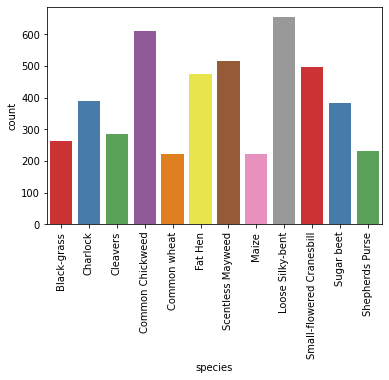

In [18]:
#Counts number of classes
g = sns.countplot(x="species", data=train, palette='Set1')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

Image data Visualisation

PLot graph

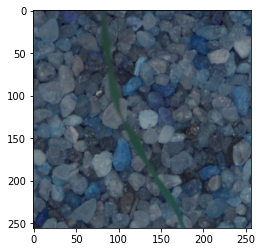

In [19]:
plt.imshow(images_std[14])

one hot encoding

In [20]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(classes))

In [21]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Model building

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(images_std, labels, test_size = 0.1, random_state=10)

In [24]:
X_train.shape, y_train.shape

((4275, 256, 256, 3), (4275, 12))

In [25]:
input_shape = X_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 3)


In [31]:
#from sklearn.metrics import accuracy_score
#from sklearn.svm import SVC
#from sklearn.metrics import roc_curve, auc
# define support vector classifier
#svm = SVC(kernel='linear', probability=True, random_state=1)
# fit model
#svm.fit(d2_train_dataset, y_train)
# generate predictions
#y_pred = svm.predict(X_test1)

# calculate accuracy
#accuracy = accuracy_score(y_test1, y_pred)
#print('Model accuracy is: ', accuracy)

In [26]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Flatten, Dense

In [27]:
model = Sequential()

input_shape = (256, 256, 3)

model.add(tf.keras.layers.InputLayer(input_shape=(256,256,3)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(50, activation='relu'))

model.add(tf.keras.layers.Dense(12, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0

Model Compilation

In [28]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = adam , loss = 'categorical_crossentropy', metrics=['accuracy'])

Model Fitting

In [29]:
history = model.fit(X_train,y_train, batch_size=32, epochs = 3,
                                  validation_data = (X_val,y_val), verbose = 1)

Epoch 1/3
134/134 [==============================] - 2881s 21s/step - loss: 2.1860 - accuracy: 0.3142 - val_loss: 1.6302 - val_accuracy: 0.4547
Epoch 2/3
134/134 [==============================] - 2872s 21s/step - loss: 1.4810 - accuracy: 0.5092 - val_loss: 1.0760 - val_accuracy: 0.6358
Epoch 3/3
134/134 [==============================] - 2873s 21s/step - loss: 1.1923 - accuracy: 0.6065 - val_loss: 1.0088 - val_accuracy: 0.6568


In [32]:
epochs = 3

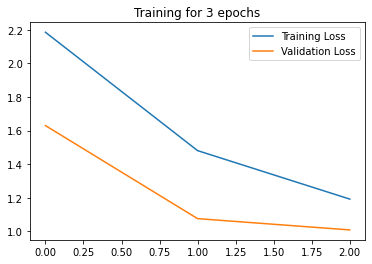

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

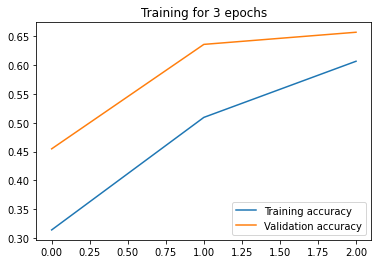

In [36]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [91]:
score = model.evaluate(X_train, y_train)
print('Training: ')
print('Train accuracy:', score[1])

score = model.evaluate(X_val, y_val)
print('validation ')
print('Test accuracy:', score[1])

134/134 [==============================] - 736s 5s/step - loss: 0.8793 - accuracy: 0.6992
Training: 
Train accuracy: 0.6991812586784363
15/15 [==============================] - 81s 5s/step - loss: 1.0088 - accuracy: 0.6568
validation 
Test accuracy: 0.6568421125411987


In [37]:
#Save model
model.save_weights('model_weights_CNN.h5f', overwrite=True)

In [39]:
# test data path "/content/drive/MyDrive/Colab Notebooks/Dataset - Plant-seedlings-classification"
test_data_folder = "Dataset - Plant-seedlings-classification/test"

test = []
for file in os.listdir(os.path.join(test_data_folder)):
    test.append(['{}/{}'.format(test_data_folder,file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test_data = []
for i in range(len(test)):
    image_bgr = cv2.imread( test['file'][i], cv2.IMREAD_COLOR)
    if image_bgr is None: # if the file contain any missig value ignore it
       continue
    x_test_data.append(image_bgr)

                                                file
0  Dataset - Plant-seedlings-classification/test/...
1  Dataset - Plant-seedlings-classification/test/...
2  Dataset - Plant-seedlings-classification/test/...
3  Dataset - Plant-seedlings-classification/test/...
4  Dataset - Plant-seedlings-classification/test/...


In [40]:
#saving resized images into images.
test_image1 = [resizeImages(img) for img in x_test_data]

In [41]:
test_images_std = np.array(test_image1)

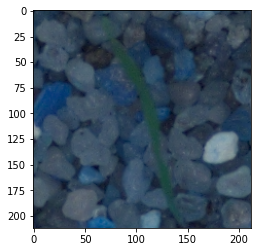

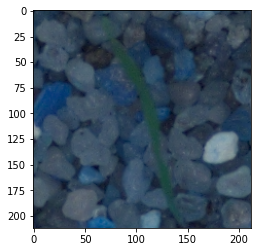

In [44]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test_data[randm]
plt.imshow(img_processed)
plt.show()

In [47]:
len(x_test_data), len(test)

(794, 794)

In [53]:
# prediction on Test Set
pred_labels = np.argmax(model.predict(test_images_std),axis = 1)

In [57]:
sample_submission = pd.read_csv('Dataset - Plant-seedlings-classification/sample_submission.csv')

In [58]:
pred_labels = pd.DataFrame(pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_data_folder):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [classes[i] for i in pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('submission.csv', index=False)
print(submission.head())

            file                    species
0  003d61042.png                    Fat Hen
1  0021e90e4.png  Small-flowered Cranesbill
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


 Suppot Vector Machine

In [63]:
# Extract last feature layer
model_feature = Model(inputs=model.input,outputs=model.get_layer('dense').output)

feature_train = model_feature.predict(X_train)
print(feature_train.shape)

(4275, 100)


In [64]:

feature_val = model_feature.predict(X_val)
print(feature_val.shape)

(475, 100)


In [65]:
feature_test = model_feature.predict(test_images_std)
print(feature_test.shape)

(794, 100)


In [67]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(feature_train,np.argmax(y_train,axis=1))


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [69]:
#  Score: Training 
svm.score(feature_train,np.argmax(y_train,axis=1))

0.8858479532163742

In [71]:
#  Score: Validation 
svm.score(feature_val,np.argmax(y_val,axis=1))

0.8210526315789474

In [72]:
#  Predict: Test 
pred_labels_svm = svm.predict(feature_test)

In [73]:

pred_labels_svm = pd.DataFrame(pred_labels_svm,index =None,columns=['species_num'])

test_df = pd.DataFrame()
test_df['species_num'] = pred_labels_svm['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [classes[i] for i in pred_labels_svm['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_svm.csv', index=False)

            file                    species
0  003d61042.png                    Fat Hen
1  0021e90e4.png  Small-flowered Cranesbill
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


2. Neural Network

In [79]:
model_nn = Sequential()

model_nn.add(tf.keras.layers.InputLayer(input_shape=(256,256,3)))
model_nn.add(tf.keras.layers.Flatten())

model_nn.add(tf.keras.layers.Dense(512,activation = "relu"))
model_nn.add(tf.keras.layers.Dropout(0.2))
# Normalization layer
model_nn.add(tf.keras.layers.BatchNormalization())

model_nn.add(tf.keras.layers.Dense(256,activation = "relu"))
model_nn.add(tf.keras.layers.Dropout(0.2))
# Normalization layer
model_nn.add(tf.keras.layers.BatchNormalization())

model_nn.add(tf.keras.layers.Dense(128,activation = "relu"))
model_nn.add(tf.keras.layers.Dropout(0.2))
# Normalization layer

model_nn.add(tf.keras.layers.BatchNormalization())
model_nn.add(tf.keras.layers.Dense(32,activation = "relu"))
model_nn.add(tf.keras.layers.Dropout(0.2))


model_nn.add(tf.keras.layers.Dense(12,activation='softmax'))
#model_nn.summary()

In [80]:
model_nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               100663808 
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)              

In [81]:
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
# Saving the best model to the checkpoint

checkpoint_ann = tf.keras.callbacks.ModelCheckpoint('plant_ANN_classifier.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

In [83]:

history_nn = model_nn.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size = 32,
          epochs=50, # Increase number of epochs if you have sufficient hardware
          callbacks = [checkpoint_ann],
          verbose = 1
)

Epoch 1/50
134/134 [==============================] - 81s 591ms/step - loss: 2.7560 - accuracy: 0.1071 - val_loss: 2.4411 - val_accuracy: 0.1411

Epoch 00001: val_accuracy improved from -inf to 0.14105, saving model to plant_ANN_classifier.h5
Epoch 2/50
134/134 [==============================] - 83s 619ms/step - loss: 2.5392 - accuracy: 0.1254 - val_loss: 2.3261 - val_accuracy: 0.1411

Epoch 00002: val_accuracy did not improve from 0.14105
Epoch 3/50
134/134 [==============================] - 77s 577ms/step - loss: 2.4079 - accuracy: 0.1717 - val_loss: 2.3242 - val_accuracy: 0.1453

Epoch 00003: val_accuracy improved from 0.14105 to 0.14526, saving model to plant_ANN_classifier.h5
Epoch 4/50
134/134 [==============================] - 82s 610ms/step - loss: 2.3658 - accuracy: 0.1715 - val_loss: 2.2514 - val_accuracy: 0.2463

Epoch 00004: val_accuracy improved from 0.14526 to 0.24632, saving model to plant_ANN_classifier.h5
Epoch 5/50
134/134 [==============================] - 83s 616ms/

In [86]:
score = model_nn.evaluate(X_train, y_train)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

134/134 [==============================] - 23s 170ms/step - loss: 2.7655 - accuracy: 0.2288
Train loss: 2.7654693126678467
Train accuracy: 0.22877192497253418


Following models are build to predit the class of a palnt
1. CNN-model: to predict the class of a plant, the model  works very well. 
But due to the limit of colab (it is active for 12 hrs) the number of epochs has to be limited, in order evaluate the model
each epoch calculation takes minimum 45 mins to complete.
so limiting the epochs to 5.

I got an accuracy 0f 0.9, with epochs = 12, but then the colab lost the connection, because it exceeds the limit.
   
Increasing number of epochs and/or adding layers to a model can even increase the performance.

combintion of CNN  Maxpooling  Dense is a good combination for image classification.

2. SVM: Model  needs data in 2D format rather than 4D (as SVM training model accepts dim <=2 so we need to convert the image data to 2D which has been done as feature extraction. The accuracy falls short

3. Neural network: works well and what features of images it considers, is important,But the accuracy is less compared to CNN model,
also fine tuning the parameters can increase the accuracy.